# TensorFlow 2 Text generator on Dante Alighieri's Divine Comedy

Author: **Ivan Bongiorni**, [LinkedIn profile](https://www.linkedin.com/in/ivan-bongiorni-b8a583164/)


This Notebook contains a **text generator RNN** that was trained on the **Divina Commedia** (the *Divine Comedy*) by **Dante Alighieri**. This is a poem written at the beginning of the XII century. It's hard to explain what it represents for Italian culture: it's without any doubt the main pillar of our national literature, one of the building blocks of modern Italian language, and arguably the gratest poem ever. All modern representations of Hell, Purgatory and Heaven derive from this opera.

It's structure is extremely interesting: each verse is composed of 11 syllables, and its rhymes follow an **A-B-A-B** structure. Lot of pattern to be learned! 

In [1]:
import time
import re

import numpy as np
import pandas as pd

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from matplotlib import pyplot as plt

# Read file from Colab Notebook
#from google.colab import drive
#drive.mount('/content/drive')

2.3.0


In [2]:
current_path = " [...] /TF_2.0/NLP/text_generator/"

# Read the Divina Commedia
with open( "DivinaCommedia.txt", 'r', encoding="utf8") as file:
    divina_commedia = file.read()

# Replace rare characters
divina_commedia = divina_commedia.replace("ä", "a")
divina_commedia = divina_commedia.replace("é", "è")
divina_commedia = divina_commedia.replace("ë", "è")
divina_commedia = divina_commedia.replace("Ë", "E")
divina_commedia = divina_commedia.replace("ï", "i")
divina_commedia = divina_commedia.replace("Ï", "I")
divina_commedia = divina_commedia.replace("ó", "ò")
divina_commedia = divina_commedia.replace("ö", "o")
divina_commedia = divina_commedia.replace("ü", "u")

divina_commedia = divina_commedia.replace("(", "-")
divina_commedia = divina_commedia.replace(")", "-")
#divina_commedia = divina_commedia.replace("[", "")
#divina_commedia = divina_commedia.replace("]", "")

divina_commedia = re.sub(r'[0-9]+', '', divina_commedia)
divina_commedia = re.sub(r'\[.*\r?\n', '', divina_commedia)
divina_commedia = re.sub(r'.*Canto.*\r?\n', '', divina_commedia)

# divina_commedia = divina_commedia.replace(" \n", "\n")  # with this i lose the "terzina": results are not so exciting
#divina_commedia = divina_commedia.replace(" \n", "<eot>")  # end of terzina
#divina_commedia = divina_commedia.replace("\n", "<eor>")

In [3]:
print(divina_commedia[1:1000])

NFERNO



Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.

Ahi quanto a dir qual era è cosa dura
esta selva selvaggia e aspra e forte
che nel pensier rinova la paura! 

Tant'è amara che poco è più morte;
ma per trattar del ben ch'i' vi trovai,
dirò de l'altre cose ch'i' v' ho scorte. 

Io non so ben ridir com'i' v'intrai,
tant'era pien di sonno a quel punto
che la verace via abbandonai. 

Ma poi ch'i' fui al piè d'un colle giunto,
là dove terminava quella valle
che m'avea di paura il cor compunto, 

guardai in alto e vidi le sue spalle
vestite già de' raggi del pianeta
che mena dritto altrui per ogne calle. 

Allor fu la paura un poco queta,
che nel lago del cor m'era durata
la notte ch'i' passai con tanta pieta. 

E come quei che con lena affannata,
uscito fuor del pelago a la riva,
si volge a l'acqua perigliosa e guata, 

così l'animo mio, ch'ancor fuggiva,
si volse a retro a rimirar lo passo
che non lasciò già mai persona viva.


In [4]:
# Check lenght of text
print(len(divina_commedia))

534048


I will now extract the set of unique characters, and create a dictionary for vectorization of text. In order to feed the text into a Neural Network, I must turn each character into a number.

In [5]:
# Store unique characters into a dict with numerical encoding
unique_chars = list(set(divina_commedia))
unique_chars.sort()  # to make sure you get the same encoding at each run

# Store them in a dict, associated with a numerical index
char2idx = { char[1]: char[0] for char in enumerate(unique_chars) }


In [6]:
print(len(char2idx))

62


In [7]:
char2idx

{'\n': 0,
 ' ': 1,
 '!': 2,
 '"': 3,
 "'": 4,
 ',': 5,
 '-': 6,
 '.': 7,
 ':': 8,
 ';': 9,
 '?': 10,
 'A': 11,
 'B': 12,
 'C': 13,
 'D': 14,
 'E': 15,
 'F': 16,
 'G': 17,
 'H': 18,
 'I': 19,
 'L': 20,
 'M': 21,
 'N': 22,
 'O': 23,
 'P': 24,
 'Q': 25,
 'R': 26,
 'S': 27,
 'T': 28,
 'U': 29,
 'V': 30,
 'Z': 31,
 'a': 32,
 'b': 33,
 'c': 34,
 'd': 35,
 'e': 36,
 'f': 37,
 'g': 38,
 'h': 39,
 'i': 40,
 'j': 41,
 'l': 42,
 'm': 43,
 'n': 44,
 'o': 45,
 'p': 46,
 'q': 47,
 'r': 48,
 's': 49,
 't': 50,
 'u': 51,
 'v': 52,
 'x': 53,
 'y': 54,
 'z': 55,
 'È': 56,
 'à': 57,
 'è': 58,
 'ì': 59,
 'ò': 60,
 'ù': 61}

Once I have a dictionary that maps each characted with its respective numerical index, I can process the whole corpus.

In [8]:
def numerical_encoding(text, char_dict):
    """ Text to list of chars, to np.array of numerical idx """
    chars_list = [ char for char in text ]
    chars_list = [ char_dict[char] for char in chars_list ]
    chars_list = np.array(chars_list)
    return chars_list


In [9]:
# Let's see what the first line will look like
print("{}".format(divina_commedia[276:511]))
print("\nbecomes:")
print(numerical_encoding(divina_commedia[276:511], char2idx))

el ben ch'i' vi trovai,
dirò de l'altre cose ch'i' v' ho scorte. 

Io non so ben ridir com'i' v'intrai,
tant'era pien di sonno a quel punto
che la verace via abbandonai. 

Ma poi ch'i' fui al piè d'un colle giunto,
là dove terminava qu

becomes:
[36 42  1 33 36 44  1 34 39  4 40  4  1 52 40  1 50 48 45 52 32 40  5  0
 35 40 48 60  1 35 36  1 42  4 32 42 50 48 36  1 34 45 49 36  1 34 39  4
 40  4  1 52  4  1 39 45  1 49 34 45 48 50 36  7  1  0  0 19 45  1 44 45
 44  1 49 45  1 33 36 44  1 48 40 35 40 48  1 34 45 43  4 40  4  1 52  4
 40 44 50 48 32 40  5  0 50 32 44 50  4 36 48 32  1 46 40 36 44  1 35 40
  1 49 45 44 44 45  1 32  1 47 51 36 42  1 46 51 44 50 45  0 34 39 36  1
 42 32  1 52 36 48 32 34 36  1 52 40 32  1 32 33 33 32 44 35 45 44 32 40
  7  1  0  0 21 32  1 46 45 40  1 34 39  4 40  4  1 37 51 40  1 32 42  1
 46 40 58  1 35  4 51 44  1 34 45 42 42 36  1 38 40 51 44 50 45  5  0 42
 57  1 35 45 52 36  1 50 36 48 43 40 44 32 52 32  1 47 51]


## RNN dataprep

I need to generate a set of stacked input sequences. My goal is to train a Neural Network to find a mapping between an input sequence and an output sequence of equal length, in which each character is shifted left of one position.

For example, the first verse:

> Nel mezzo del cammin di nostra vita

would be translated in a train sequence as:

`Nel mezzo del cammin di nostra vit`

be associated with the target sequence:

`el mezzo del cammin di nostra vita`

The following function is a preparatory step for that. More generally, given a sequence:

```
A B C D E F G H I
```

and assuming input sequences of length 5, it will generate a matrix like:

```
A B C D E
B C D E F
C D E F G
D E F G H
E F G H I
```

I will save that matrix as it is in .csv format, to use it to train the Language Generator later.
The split between train and target sets will be as:

```
 Train:           Target:
                 
A B C D E        B C D E F
B C D E F        C D E F G
C D E F G        D E F G H
D E F G H        E F G H I
                 
```

Train and target sets are fundamentally the same matrix, with the train having the last row removed, and the target set having the first removed.

In [10]:
# Apply it on the whole Comedy
encoded_text = numerical_encoding(divina_commedia, char2idx)

In [11]:
print(encoded_text[311:600])

[42 50 48 36  1 34 45 49 36  1 34 39  4 40  4  1 52  4  1 39 45  1 49 34
 45 48 50 36  7  1  0  0 19 45  1 44 45 44  1 49 45  1 33 36 44  1 48 40
 35 40 48  1 34 45 43  4 40  4  1 52  4 40 44 50 48 32 40  5  0 50 32 44
 50  4 36 48 32  1 46 40 36 44  1 35 40  1 49 45 44 44 45  1 32  1 47 51
 36 42  1 46 51 44 50 45  0 34 39 36  1 42 32  1 52 36 48 32 34 36  1 52
 40 32  1 32 33 33 32 44 35 45 44 32 40  7  1  0  0 21 32  1 46 45 40  1
 34 39  4 40  4  1 37 51 40  1 32 42  1 46 40 58  1 35  4 51 44  1 34 45
 42 42 36  1 38 40 51 44 50 45  5  0 42 57  1 35 45 52 36  1 50 36 48 43
 40 44 32 52 32  1 47 51 36 42 42 32  1 52 32 42 42 36  0 34 39 36  1 43
  4 32 52 36 32  1 35 40  1 46 32 51 48 32  1 40 42  1 34 45 48  1 34 45
 43 46 51 44 50 45  5  1  0  0 38 51 32 48 35 32 40  1 40 44  1 32 42 50
 45  1 36  1 52 40 35 40  1 42 36  1 49 51 36  1 49 46 32 42 42 36  0 52
 36]


In [12]:
def get_text_matrix(sequence, len_input):
    
    # create empty matrix
    X = np.empty((len(sequence)-len_input, len_input))
    
    # fill each row/time window from input sequence
    for i in range(X.shape[0]):
        X[i,:] = sequence[i : i+len_input]
        
    return X

In [13]:
text_matrix = get_text_matrix(encoded_text, 100)

In [14]:
print(text_matrix.shape)

(533948, 100)


In [15]:
print("100th train sequence:\n")
print(text_matrix[ 100, : ])
print("\n\n100th target sequence:\n")
print(text_matrix[ 101, : ])
print("\n\n102th target sequence:\n")
print(text_matrix[ 102, : ])
print("\n\n115th target sequence:\n")
print(text_matrix[ 180, : ])

100th train sequence:

[36. 48. 32.  1. 49. 43. 32. 48. 48. 40. 50. 32.  7.  0.  0. 11. 39. 40.
  1. 47. 51. 32. 44. 50. 45.  1. 32.  1. 35. 40. 48.  1. 47. 51. 32. 42.
  1. 36. 48. 32.  1. 58.  1. 34. 45. 49. 32.  1. 35. 51. 48. 32.  0. 36.
 49. 50. 32.  1. 49. 36. 42. 52. 32.  1. 49. 36. 42. 52. 32. 38. 38. 40.
 32.  1. 36.  1. 32. 49. 46. 48. 32.  1. 36.  1. 37. 45. 48. 50. 36.  0.
 34. 39. 36.  1. 44. 36. 42.  1. 46. 36.]


100th target sequence:

[48. 32.  1. 49. 43. 32. 48. 48. 40. 50. 32.  7.  0.  0. 11. 39. 40.  1.
 47. 51. 32. 44. 50. 45.  1. 32.  1. 35. 40. 48.  1. 47. 51. 32. 42.  1.
 36. 48. 32.  1. 58.  1. 34. 45. 49. 32.  1. 35. 51. 48. 32.  0. 36. 49.
 50. 32.  1. 49. 36. 42. 52. 32.  1. 49. 36. 42. 52. 32. 38. 38. 40. 32.
  1. 36.  1. 32. 49. 46. 48. 32.  1. 36.  1. 37. 45. 48. 50. 36.  0. 34.
 39. 36.  1. 44. 36. 42.  1. 46. 36. 44.]


102th target sequence:

[32.  1. 49. 43. 32. 48. 48. 40. 50. 32.  7.  0.  0. 11. 39. 40.  1. 47.
 51. 32. 44. 50. 45.  1. 32.  1. 35. 4

# Architecture

At this point, I can specify the RNN architecture with all its hyperparameters. An `Embedding()` layer will first learn a representation of each character; the sequence of chracters embedding will then be fed into an `LSTM()` layer, that will extract information from their sequence; `Dense()` layers at the end will produce the next character prediction.

The Network is structured to be fed with batches of data of fixed size.

In [17]:
# size of vocabulary
vocab_size = len(char2idx)

# size of mini batches during training
batch_size = 200  # 100


# size of training subset at each epoch
subset_size = batch_size * 100

# vector size of char embeddings
embedding_size = 300  # 250

len_input = 1024   # 200

hidden_size = 300  # for Dense() layers 250

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.activations import elu, relu, softmax

In [18]:
'''
EXPERIMENT
MODEL
'''
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Attention, Flatten, Input
from tensorflow.keras.activations import elu, relu, softmax
from tensorflow.keras.metrics import categorical_accuracy, sparse_categorical_crossentropy, categorical_crossentropy
# Define custom training utilities that are widely used for language modelling

n_epochs = 200

learning_rate = 0.001  # 0.0001
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)  # Adam

def loss(y_true, y_pred):
    """Calculates categorical crossentropy as loss"""
    return categorical_crossentropy(y_true=y_true, y_pred=y_pred)


def perplexity(labels, logits):
    """Calculates perplexity metric = 2^(entropy) or e^(entropy)"""
    return pow(2, loss(y_true=labels, y_pred=logits))

# Input Layer
X = Input(shape=(None, ), batch_size=batch_size)  # 100 is the number of features

# Word-Embedding Layer
embedded = Embedding(vocab_size, embedding_size, batch_input_shape=(batch_size, None))(X)
embedded = Dense(embedding_size, relu)(embedded)
encoder_output, hidden_state, cell_state = LSTM(units=2048,
                                                         return_sequences=True,
                                                         return_state=True)(embedded)
#attention_input = [encoder_output, hidden_state]

encoder_output = Dense(embedding_size, activation='relu')(encoder_output)

#encoder_output = Attention()(attention_input, training=True)

encoder_output, hidden_state, cell_state = LSTM(units=2048,
                                                         return_sequences=True,
                                                         return_state=True)(encoder_output, initial_state=[hidden_state, cell_state])
#encoder_output = Flatten()(encoder_output)
encoder_output = Dense(hidden_size, activation='relu')(encoder_output)
# Prediction Layer
Y = Dense(units=vocab_size)(encoder_output)

# Compile model
model = Model(inputs=X, outputs=Y)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), optimizer='adam', metrics=[perplexity, sparse_categorical_crossentropy])
print(model.summary())

# This is an Autograph function
# its decorator makes it a TF op - i.e. much faster
@tf.function
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        current_loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(
                y, model(x), from_logits = True))
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return current_loss


loss_history = []

for epoch in range(n_epochs):
    start = time.time()
    
    # Take subsets of train and target
    sample = np.random.randint(0, text_matrix.shape[0]-1, subset_size)
    sample_train = text_matrix[ sample , : ]
    sample_target = text_matrix[ sample+1 , : ]
    
    for iteration in range(sample_train.shape[0] // batch_size):
        take = iteration * batch_size
        x = sample_train[ take:take+batch_size , : ]
        y = sample_target[ take:take+batch_size , : ]

        current_loss = train_on_batch(x, y)
        loss_history.append(current_loss)
    
    print("{}.  \t  Loss: {}  \t  Time: {}sec/epoch".format(
        epoch+1, current_loss.numpy(), round(time.time()-start, 2)))
    


'''
EXPERIMENT
GENERATOR
'''

# Input Layer
X = Input(shape=(None, ), batch_size=1)  # 100 is the number of features

# Word-Embedding Layer
embedded = Embedding(vocab_size, embedding_size, batch_input_shape=(batch_size, None))(X)
embedded = Dense(embedding_size, relu)(embedded)
encoder_output, hidden_state, cell_state = LSTM(units=2048,
                                                         return_sequences=True,
                                                         return_state=True,
                                                stateful=True)(embedded)
#attention_input = [encoder_output, hidden_state]

encoder_output = Dense(embedding_size, activation='relu')(encoder_output)

#encoder_output = Attention()(attention_input, training=True)

encoder_output, hidden_state, cell_state = LSTM(units=2048,
                                                         return_sequences=True,
                                                         return_state=True,
                                                stateful=True)(encoder_output, initial_state=[hidden_state, cell_state])
#encoder_output = Flatten()(encoder_output)
encoder_output = Dense(hidden_size, activation='relu')(encoder_output)
# Prediction Layer
Y = Dense(units=vocab_size)(encoder_output)

# Compile model
generator = Model(inputs=X, outputs=Y)
generator.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), optimizer='adam', metrics=[perplexity, sparse_categorical_crossentropy])
print(model.summary())


# Import trained weights from model to generator
generator.set_weights(model.get_weights())

def generate_text(start_string, num_generate = 1000, temperature = 1.0):
    
    # Vectorize input string
    input_eval = [char2idx[s] for s in start_string]  
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = [] # List to append predicted chars 
    
    idx2char = { v: k for k, v in char2idx.items() }  # invert char-index mapping
    
    generator.reset_states()
    
    for i in range(num_generate):
        predictions = generator(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # sample next char based on distribution and temperature
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
        
    return (start_string + ''.join(text_generated))


# Let's feed the first lines:
start_string = """
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.

"""

for t in [0.1, 0.5, 1.0, 1.5, 2]:
    print("####### TEXT GENERATION - temperature = {}\n".format(t))
    print(generate_text(start_string = start_string, num_generate = 1000, temperature = t))
    print("\n\n\n")

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(200, None)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (200, None, 300)     18600       input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (200, None, 300)     90300       embedding[0][0]                  
__________________________________________________________________________________________________
lstm (LSTM)                     [(200, None, 2048),  19243008    dense[0][0]                      
_______________________________________________________________________________________

In [ ]:
RNN = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(batch_size, None)),
    Dense(embedding_size, activation = relu),
    
    LSTM(len_input, return_sequences = True),

    Dropout(0.3),
    
    Dense(hidden_size, activation = relu), 

    Dropout(0.3),

    LSTM(len_input, return_sequences = True),
    
    Dense(vocab_size)
])

RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (200, None, 300)          18600     
_________________________________________________________________
dense (Dense)                (200, None, 300)          90300     
_________________________________________________________________
lstm (LSTM)                  (200, None, 1024)         5427200   
_________________________________________________________________
dropout (Dropout)            (200, None, 1024)         0         
_________________________________________________________________
dense_1 (Dense)              (200, None, 300)          307500    
_________________________________________________________________
dropout_1 (Dropout)          (200, None, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (200, None, 1024)         5

In [ ]:
n_epochs = 20

learning_rate = 0.001  # 0.0001
optimizer = tf.keras.optimizers.Adamax(learning_rate = learning_rate)  # Adam

In [ ]:
# This is an Autograph function
# its decorator makes it a TF op - i.e. much faster
@tf.function
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        current_loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(
                y, RNN(x), from_logits = True))
    gradients = tape.gradient(current_loss, RNN.trainable_variables)
    optimizer.apply_gradients(zip(gradients, RNN.trainable_variables))
    return current_loss

In [ ]:
loss_history = []

for epoch in range(n_epochs):
    start = time.time()
    
    # Take subsets of train and target
    sample = np.random.randint(0, text_matrix.shape[0]-1, subset_size)
    sample_train = text_matrix[ sample , : ]
    sample_target = text_matrix[ sample+1 , : ]
    
    for iteration in range(sample_train.shape[0] // batch_size):
        take = iteration * batch_size
        x = sample_train[ take:take+batch_size , : ]
        y = sample_target[ take:take+batch_size , : ]

        current_loss = train_on_batch(x, y)
        loss_history.append(current_loss)
    
    print("{}.  \t  Loss: {}  \t  Time: {}ss".format(
        epoch+1, current_loss.numpy(), round(time.time()-start, 2)))

1.  	  Loss: 2.9850523471832275  	  Time: 51.65ss
2.  	  Loss: 2.395160436630249  	  Time: 50.83ss
3.  	  Loss: 2.1662957668304443  	  Time: 50.68ss
4.  	  Loss: 2.0440170764923096  	  Time: 50.71ss
5.  	  Loss: 1.9688301086425781  	  Time: 50.72ss
6.  	  Loss: 1.8783867359161377  	  Time: 50.68ss
7.  	  Loss: 1.8288464546203613  	  Time: 50.73ss
8.  	  Loss: 1.7976200580596924  	  Time: 50.65ss
9.  	  Loss: 1.750290870666504  	  Time: 50.76ss
10.  	  Loss: 1.7273554801940918  	  Time: 50.68ss
11.  	  Loss: 1.6812254190444946  	  Time: 50.65ss
12.  	  Loss: 1.6205040216445923  	  Time: 50.74ss
13.  	  Loss: 1.595969796180725  	  Time: 50.67ss
14.  	  Loss: 1.5555707216262817  	  Time: 50.72ss
15.  	  Loss: 1.5181407928466797  	  Time: 50.72ss
16.  	  Loss: 1.501092791557312  	  Time: 50.77ss
17.  	  Loss: 1.4644851684570312  	  Time: 50.7ss
18.  	  Loss: 1.4569607973098755  	  Time: 50.63ss
19.  	  Loss: 1.4066871404647827  	  Time: 50.63ss
20.  	  Loss: 1.3883055448532104  	  Time: 50

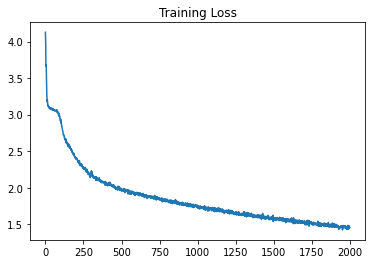

In [ ]:
plt.plot(loss_history)
plt.title("Training Loss")
plt.show()

In [ ]:
RNN.save( "text_generator_RNN_03.h5")

# Text Generation

At this point, let's check how the model generates text. In order to do it, I must make some changes to my RNN architecture above.

First, I must change the fixed batch size. After training, I want to feed just one sentence into my Network to make it continue the character sequence. I will feed a string into the model, make it predict the next character, update the input sequence, and repeat the process until a long generated text is obtained. Because of this, the succession of input sequences is now different from training session, in which portions of text were sampled randomly. I now have to set `stateufl = True` in the `LSTM()` layer, so that each LSTM cell will keep in memory the internal state from the previous sequence. With this I hope the model will better remember sequential information while generating text.

I will instantiate a new `generator` RNN with these new features, and transfer the trained weights of my `RNN` into it.

In [ ]:
generator = Sequential([
   Embedding(vocab_size, embedding_size,
              batch_input_shape=(1, None)),
    Dense(embedding_size, activation = relu),
    
    LSTM(len_input, return_sequences = True, stateful=1),

    Dropout(0.3),
    
    Dense(hidden_size, activation = relu), 

    Dropout(0.3),

    LSTM(len_input, return_sequences = True, stateful=1),
    
    Dense(vocab_size)
])

generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 300)            18600     
_________________________________________________________________
dense_9 (Dense)              (1, None, 300)            90300     
_________________________________________________________________
lstm_6 (LSTM)                (1, None, 1024)           5427200   
_________________________________________________________________
dropout_6 (Dropout)          (1, None, 1024)           0         
_________________________________________________________________
dense_10 (Dense)             (1, None, 300)            307500    
_________________________________________________________________
dropout_7 (Dropout)          (1, None, 300)            0         
_________________________________________________________________
lstm_7 (LSTM)                (1, None, 1024)          

In [ ]:
# Import trained weights from RNN to generator
generator.set_weights(RNN.get_weights())

In [ ]:
def generate_text(start_string, num_generate = 1000, temperature = 1.0):
    
    # Vectorize input string
    input_eval = [char2idx[s] for s in start_string]  
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = [] # List to append predicted chars 
    
    idx2char = { v: k for k, v in char2idx.items() }  # invert char-index mapping
    
    generator.reset_states()
    
    for i in range(num_generate):
        predictions = generator(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # sample next char based on distribution and temperature
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
        
    return (start_string + ''.join(text_generated))


(This function is based on [this tutorial](https://www.tensorflow.org/tutorials/text/text_generation).)

In [ ]:
# Let's feed the first lines:
start_string = """
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.

"""

for t in [0.1, 0.5, 1.0, 1.5, 2]:
    print("####### TEXT GENERATION - temperature = {}\n".format(t))
    print(generate_text(start_string = start_string, num_generate = 1000, temperature = 1.0))
    print("\n\n\n")

####### TEXT GENERATION - temperature = 0.1


Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.



Ora questo che tenna con esso pianta,
fonno de li altri rispiose poscegno,
che idronemo e menera a fruttorna
nei perchè tanta inverno, tutte 'l puoi".



in vendi ' pietra il tanto parte era,
primandono entro, evei nè me si stesse
buono alqual ch'ogne non aperto leto
ch'el tanto inghiecco quell'ca divina. 

Quasi alloral lorar com'io duca;
e riguarrille, duo per malco a brace
me che già veglia, quanto purto colpa
fora d'un che, profodo scallegio
ch'io disse: "E questo fiate menore. 

Centor Berve fui che tant' io luoto:
chè, quando le cagion che s'accriga una;
la cima prei del vide, ed esse, anda
sodra, andarata drite, e il trascosto,
il parlarento e 'l pèotò come avveggia,
tal che d'angella sua leggia condetta,
sopr'alla voi di mezzo solo è benno. 

Io mi fua lantia, inverabon pria 'ntrima
di ruoi senti
la vente mio menando me ormi?",


The best generation is, IMHO, the one with `temperature = 1.5`. The sentences of course do not make sense, but it's amazing that such a simple model could achieve similar results, and generate absolutely Dante-esque text with just ~40 minutes of GPU training.

Many things could be done at this point:



*   Try fancier architectures, such as seq2seq. (I must say though that stacked RNNs didn't provide better results during prototyping.)
*   Try Attention models.
*   Longer training.
*   Adversarial training.

I'll try a lot of these techniques, alone and combined. My goal is to make a model that can learn the amazing structure of syllables and rhymes of the whole Comedy.



# NEW IDEAS

#### Training:
*   Cross validation
*   Insert Rhyme as feature to learn as haiku
*   Use syllable as input and not word
*   Different training on different dataset
* Use categorical_crossentropy instead of sparse_ but with one-hot encoded inputs
* Symbols for explicit start and end terzina
* training as classificator for structure: like "these two world are rhymes" or "this is a endecasillable and this not" or "this is a terzina and this not" then generation
* use dropout 
* use two lstm
* 

#### Presentation
* graphs over the vocabulary like distribution of used words




In [ ]:
RNN = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(batch_size, None)),
              
    Dense(embedding_size, activation = relu),
    
    LSTM(len_input, return_sequences = True),

    Dropout(0.3),
    
    Dense(hidden_size, activation = relu), 

    Dropout(0.3),
    
    Dense(vocab_size)
])

RNN.summary()

generator = Sequential([
    Embedding(vocab_size, embedding_size,batch_input_shape=(1, None)),

    Dense(embedding_size, activation = relu),
    
    LSTM(len_input, return_sequences = True, stateful=True),

    Dropout(0.3),
    
    Dense(hidden_size, activation = relu), 

    Dropout(0.3),
    
    Dense(vocab_size)


])

generator.summary()